In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')


import operator

import re
import seaborn as sns

from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
path ='https://raw.githubusercontent.com/tanvi-ap/ClimateChange_StanceDetection/main/Climate_change_train.csv'
r = requests.get(path)
train_df = pd.read_csv(io.StringIO(r.text),index_col=0)

train_df.sample(5)

,Target,Tweet,Stance
ID,,,
752,Climate Change is a Real Concern,"First listen, then conviction, next action - D...",NONE
689,Climate Change is a Real Concern,@washingtonpost That is one of the most INSANE...,NONE
614,Climate Change is a Real Concern,"We cant deny it, its really happening. #SemST",FAVOR
944,Climate Change is a Real Concern,Second heatwave hits NA NW popping up everywhe...,FAVOR
860,Climate Change is a Real Concern,At the UN with crew now :) @Trashis4Tossers #S...,NONE


In [ ]:
train_df['Stance'].value_counts()

FAVOR      335
NONE       203
AGAINST     26
Name: Stance, dtype: int64

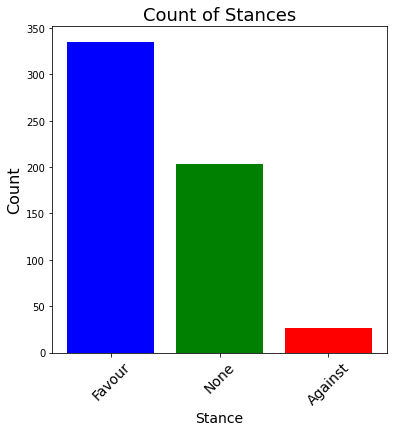

In [ ]:
## Plot a distribution of the dataset
plt.figure(figsize=(6,6))
Index = [1,2,3]
Mood_count = train_df['Stance'].value_counts()

plt.bar(Index, Mood_count, color=['blue','green', 'red'])
plt.xticks(Index,['Favour','None','Against'],rotation=45, fontsize=14)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Stance', fontsize=14)
plt.title('Count of Stances', fontsize=18)
#plt.annotate(text = Mood_count[0], xy = (0.13,22000), size = 18,s=None)

plt.savefig('sentiments_count.png')

count    564.000000
mean      16.599291
std        4.288329
min        7.000000
25%       13.000000
50%       17.000000
75%       20.000000
max       27.000000
dtype: float64


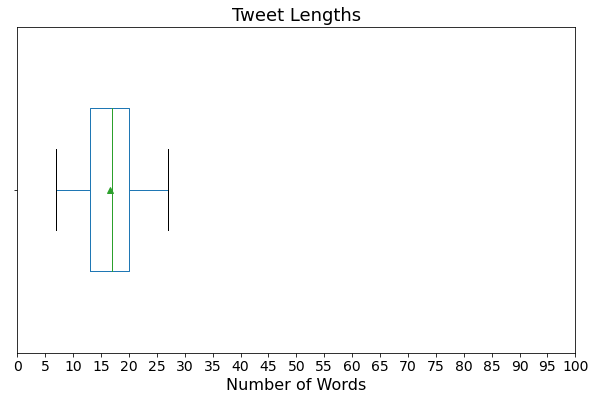

In [ ]:
# Calculate tweet lengths
plt.figure(figsize=(10,6))
tweet_len = pd.Series([len(tweet.split()) for tweet in train_df['Tweet']])
print(tweet_len.describe())

# The distribution of tweet text lengths
green_diamond = dict(markerfacecolor='g', marker='D')
tweet_len.plot(kind='box', vert=False, widths=0.5, 
               showmeans=True,
               flierprops=green_diamond)
plt.xlabel('Number of Words', fontsize=16)
plt.xticks(np.arange(0, 101, 5), fontsize=14)
plt.yticks([1], " ")
plt.title("Tweet Lengths", fontsize=18)
plt.show()

In [ ]:
df_new = train_df.copy()
df_new['length'] = train_df['Tweet'].str.split().apply(len)
df_new.head()

,Target,Tweet,Stance,length
ID,,,,
10221,Climate Change is a Real Concern,Closed door session begins. More after they de...,NONE,13
10222,Climate Change is a Real Concern,What is the #energiewende agenda? Why are they...,FAVOR,21
10223,Climate Change is a Real Concern,@climasphere Stocker: Fish catch potential cou...,FAVOR,20
10224,Climate Change is a Real Concern,"...a longer memory, and a sterner sense of jus...",NONE,14
10225,Climate Change is a Real Concern,"Boni ""Future Sea level rise will not be unifor...",FAVOR,16


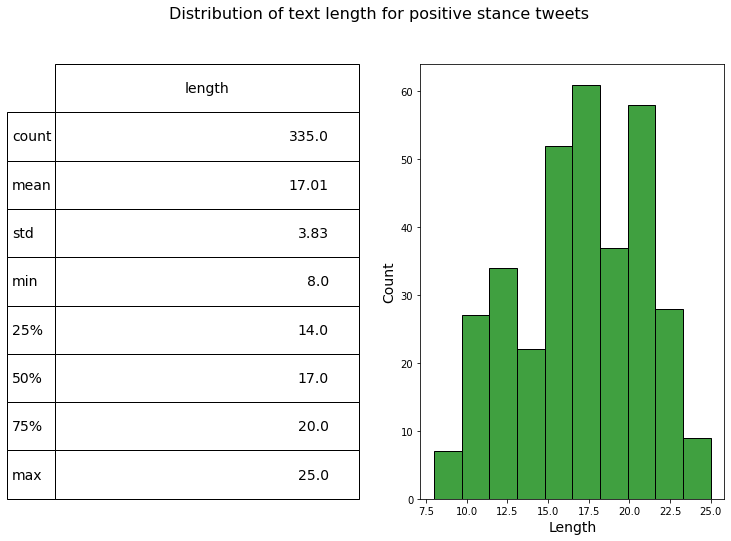

In [ ]:
# Plotting the distribution of text length for Favor stance tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['Stance']=='FAVOR']['length'], ax=ax1,color='green')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['Stance']=='FAVOR'].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive stance tweets', fontsize=16)

plt.show()

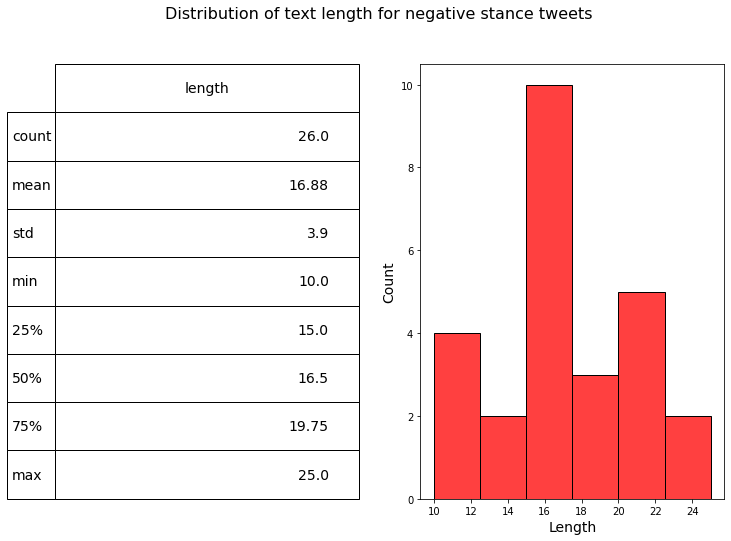

In [ ]:
# Plotting the distribution of text length for Against tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['Stance']=='AGAINST']['length'], ax=ax1,color='red')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['Stance']=='AGAINST'].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative stance tweets', fontsize=16)

plt.show()

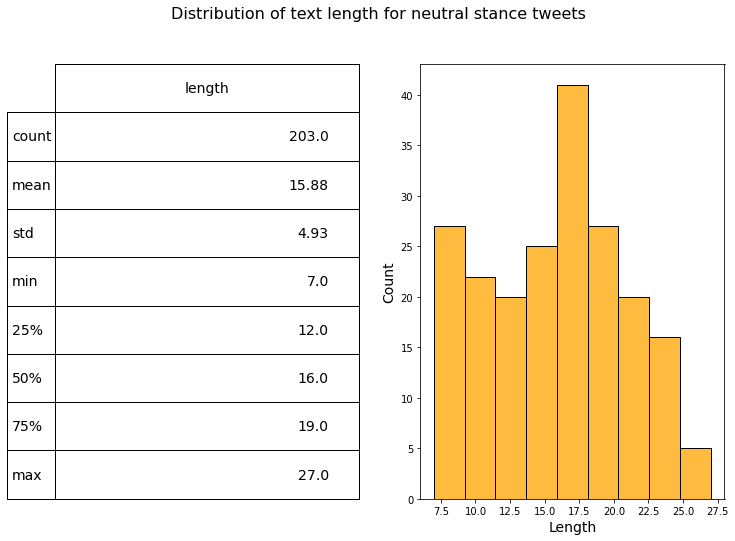

In [ ]:
# Plotting the distribution of text length for NONE stance tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['Stance']=='NONE']['length'], ax=ax1,color='orange')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['Stance']=='NONE'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral stance tweets', fontsize=16)

plt.show()

In [ ]:
## Count the frequency of words in a dictionary
def count_frequency(dictionary, words):
    for word in words:
        if word not in dictionary.keys():
            dictionary[word] = 1
        else:
            dictionary[word] += 1
    return dictionary

In [ ]:
favour_stance = {}
no_stance = {}
against_stance = {}

for i in range(0,len(train_df)):
    tweet = train_df['Tweet'].iloc[i]
    tweet = tweet.lower()
    new  = re.sub('[^A-Za-z0-9]+', ' ', tweet) ## Need to get rid of special characters next
    tokens = nltk.word_tokenize(new) ## word_tokenize does not remove duplicates
  
    ## Preserve the order because calling set does not preserve the order of the words
    ordered_tokens = set()
    result = []
    for word in tokens:
        if word not in ordered_tokens:
            ordered_tokens.add(word)
            result.append(word)
            
    if (train_df['Stance'].iloc[i] == 'FAVOR'):
        count_frequency(favour_stance, result) 
    elif (train_df['Stance'].iloc[i] == 'NONE'):
        count_frequency(no_stance, result) 
    else:
        count_frequency(against_stance, result)

In [ ]:
pos = sorted(favour_stance.items(),key=operator.itemgetter(1), reverse=True)
neut = sorted(no_stance.items(),key=operator.itemgetter(1), reverse=True)
neg = sorted(against_stance.items(),key=operator.itemgetter(1), reverse=True)

In [ ]:
## Create dataframe from a list of tuples
df_pos = pd.DataFrame(pos, columns = ['word', 'frequency']) 
df_neut = pd.DataFrame(neut, columns = ['word', 'frequency'])
df_neg = pd.DataFrame(neg, columns = ['word', 'frequency'])

print("The number of words in tweets with POSITIVE stance is", len(df_pos))
print("The number of words in tweets with NO stance is", len(df_neut))
print("The number of words in tweets with NEGATIVE stance is", len(df_neg))

The number of words in tweets with POSITIVE stance is 2104
The number of words in tweets with NO stance is 1437
The number of words in tweets with NEGATIVE stance is 276


In [ ]:
# A list of dataframes
frame_list = [df_pos, df_neut, df_neg]
inter_all = frame_list[0]
for df in frame_list[1:]:       
    inter_all = pd.merge(inter_all, df, on='word', how='inner')
inter_all = inter_all.rename(columns = {"frequency_x": "positive stance", 
                                        "frequency_y": "neutral stance",
                                       "frequency": "negative stance"})

print("The number of words appearing in tweets with all of positive, neutral, and negative stance is", 
      len(inter_all))
inter_all.head()

The number of words appearing in tweets with all of positive, neutral, and negative stance is 107


,word,positive stance,neutral stance,negative stance
0,semst,335,203,26
1,the,140,88,15
2,to,118,63,7
3,is,84,45,3
4,of,83,47,4


In [ ]:
inter_pos_neutral = pd.merge(df_pos, df_neut, how = 'inner', on = ['word'])
inter_pos_neutral = inter_pos_neutral.rename(columns = {"frequency_x": "positive stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is", len(inter_pos_neutral))
inter_pos_neutral.head(10)

The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is 547


,word,positive stance,neutral stance
0,semst,335,203
1,the,140,88
2,to,118,63
3,is,84,45
4,of,83,47
5,in,79,37
6,a,68,36
7,and,66,24
8,we,60,16
9,on,47,35


In [ ]:
inter_pos_neg = pd.merge(df_pos, df_neg, how = 'inner', on = ['word'])
inter_pos_neg = inter_pos_neg.rename(columns={"frequency_x": "positive stance", "frequency_y": "negative stance"})
print("The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is", len(inter_pos_neg))
inter_pos_neg.head(10)

The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is 155


,word,positive stance,negative stance
0,semst,335,26
1,the,140,15
2,to,118,7
3,is,84,3
4,of,83,4
5,in,79,7
6,climate,77,6
7,a,68,7
8,and,66,6
9,we,60,1


In [ ]:
inter_neg_neut = pd.merge(df_neg, df_neut, how = 'inner', on = ['word'])
inter_neg_neut = inter_neg_neut.rename(columns={"frequency_x": "negative stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is", len(inter_neg_neut))
inter_neg_neut.head(10)

The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is 121


,word,negative stance,neutral stance
0,semst,26,203
1,the,15,88
2,in,7,37
3,to,7,63
4,a,7,36
5,change,6,3
6,and,6,24
7,be,6,23
8,on,5,35
9,of,4,47


In [ ]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe 
## and the neutral stance dataframe

df_pos = df_pos.rename(columns={"frequency": "positive stance"})

## Remove duplicates of words with a negative stance
df_inter = inter_pos_neg[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))
df1 = pd.concat([df_pos, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df1))

df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral stance
df_inter = inter_pos_neutral[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))

df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'positive stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_pos_unique = df3.copy()
print("\nThe number of words that correspond only to POSITIVE stance are:", len(df_pos_unique))
print("\n The most common words that correspond only to POSITIVE stance are:")
df_pos_unique.head(20)

The number of words overlapping with positive and negative stance is 155
The length BEFORE dropping duplicates is 2259
The length AFTER dropping duplicates is 1949

The number of words overlapping with positive and neutral stance is 547
The length BEFORE dropping duplicates is 2496
The length AFTER dropping duplicates is 1616

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 107
The length BEFORE dropping duplicates is 1723
The length AFTER dropping duplicates is 1509

The number of words that correspond only to POSITIVE stance are: 1509

 The most common words that correspond only to POSITIVE stance are:


,word,positive stance
28,cfcc15,21
32,mission,19
33,tip,19
51,emissions,13
67,green,10
72,actonclimate,9
81,sea,8
82,level,8
85,power,8
87,generation,8


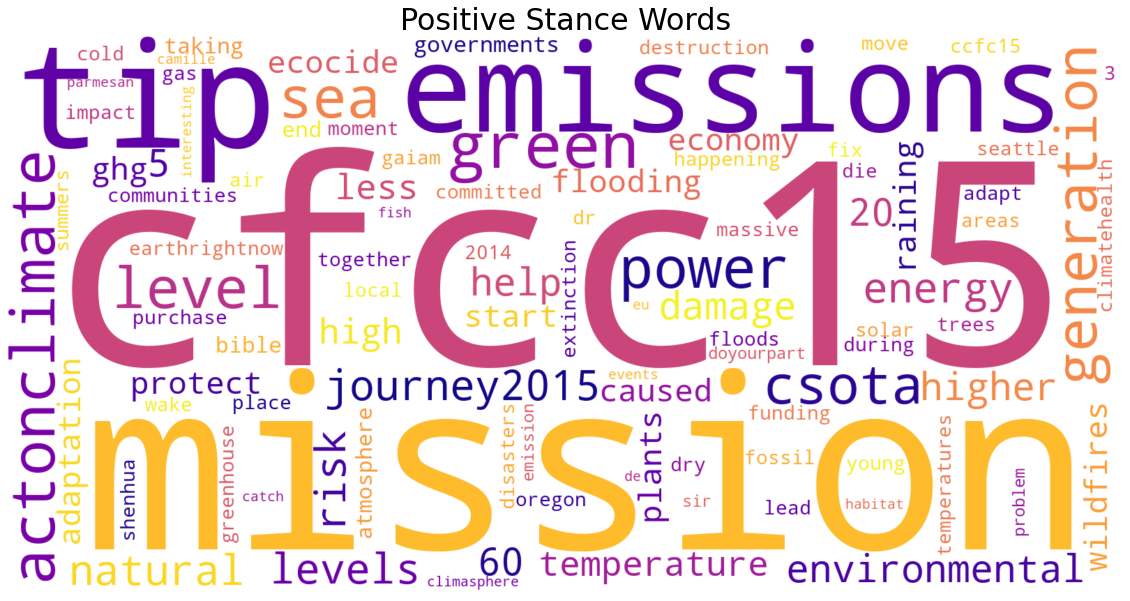

In [ ]:
# https://www.datacamp.com/community/tutorials/wordcloud-python 
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

## Make a word cloud of words the correspond to positive stance only
positive_dict = df_pos_unique.set_index('word').T.to_dict('records')

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               colormap = "plasma",
               background_color="white").generate_from_frequencies(positive_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Positive Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("positive_sent.png")

In [ ]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe
## and neutral stance dataframe

df_neg = df_neg.rename(columns={"frequency": "negative stance"})
print("The number of words with NEGATIVE stance", len(df_neg))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neg[['word', 'negative stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))

df1 = pd.concat([df_neg, df_inter], axis=0)
print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral sentiment
df_inter = inter_neg_neut[['word', 'negative stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'negative stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neg_unique = df3.copy()
print("\nThe number of words that correspond only to NEGATIVE stance are:", len(df_neg_unique))
print("\nThe most common words that correspond only to NEGATIVE stance are:")
df_neg_unique.head(20)

The number of words with NEGATIVE stance 276
The number of words overlapping with positive and negative stance is 155
The length BEFORE dropping duplicates is 431
The length AFTER dropping duplicates is 121

The number of words overlapping with negative and neutral stance is 121
The length BEFORE dropping duplicates is 242
The length AFTER dropping duplicates is 214

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 107
The length BEFORE dropping duplicates is 321
The length AFTER dropping duplicates is 107

The number of words that correspond only to NEGATIVE stance are: 107

The most common words that correspond only to NEGATIVE stance are:


,word,negative stance
22,glblwarmingnews,3
23,tooth,3
24,fairy,3
29,teeth,3
30,carbontaxscam,3
39,alarmists,2
43,wakeupamerica,2
50,volcano,1
51,emits,1
56,cracking,1


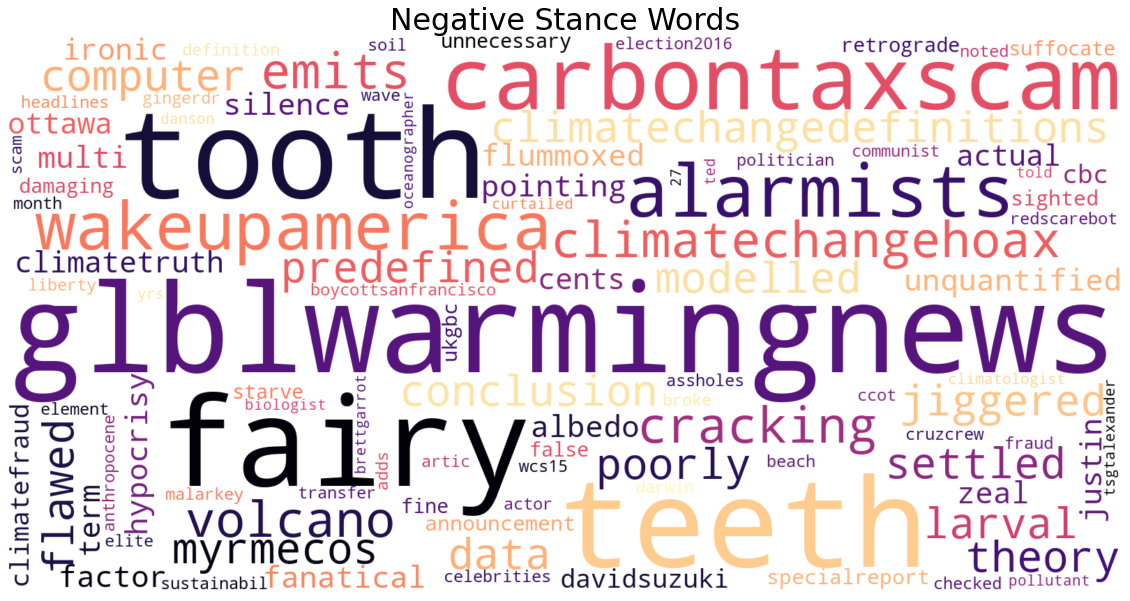

In [ ]:
negative_dict = df_neg_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to negative stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800, 
               background_color="white",
               colormap = "magma").generate_from_frequencies(negative_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Negative Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("negative_sent.png")

In [ ]:
# Remove all words from the neutral stance dataframe that overlap with the negative stance dataframe 
# nd positive stance dataframe

df_neut = df_neut.rename(columns={"frequency": "neutral stance"})
print("The number of words with NEUTRAL stance", len(df_neut))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neutral[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df1 = pd.concat([df_neut, df_inter], axis=0)

print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a negative stance
df_inter = inter_neg_neut[['word', 'neutral stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neutral_unique = df3.copy()
print("\nThe number of words that correspond only to NEUTRAL stance are:", len(df_neutral_unique))
print("\nThe most common words that correspond only to NEUTRAL stance are:")
df_neutral_unique.head(20)

The number of words with NEUTRAL stance 1437
The number of words overlapping with positive and neutral stance is 547
The length BEFORE dropping duplicates is 1984
The length AFTER dropping duplicates is 890

The number of words overlapping with negative and neutral stance is 121
The length BEFORE dropping duplicates is 1011
The length AFTER dropping duplicates is 983

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 107
The length BEFORE dropping duplicates is 1090
The length AFTER dropping duplicates is 876

The number of words that correspond only to NEUTRAL stance are: 876

The most common words that correspond only to NEUTRAL stance are:


,word,neutral stance
98,lovewins,5
113,valkilmer,4
121,gms,3
122,transparency,3
132,key,3
148,popefrancis,3
152,smackoff,3
160,tcot,3
169,democratic,3
171,proof,3


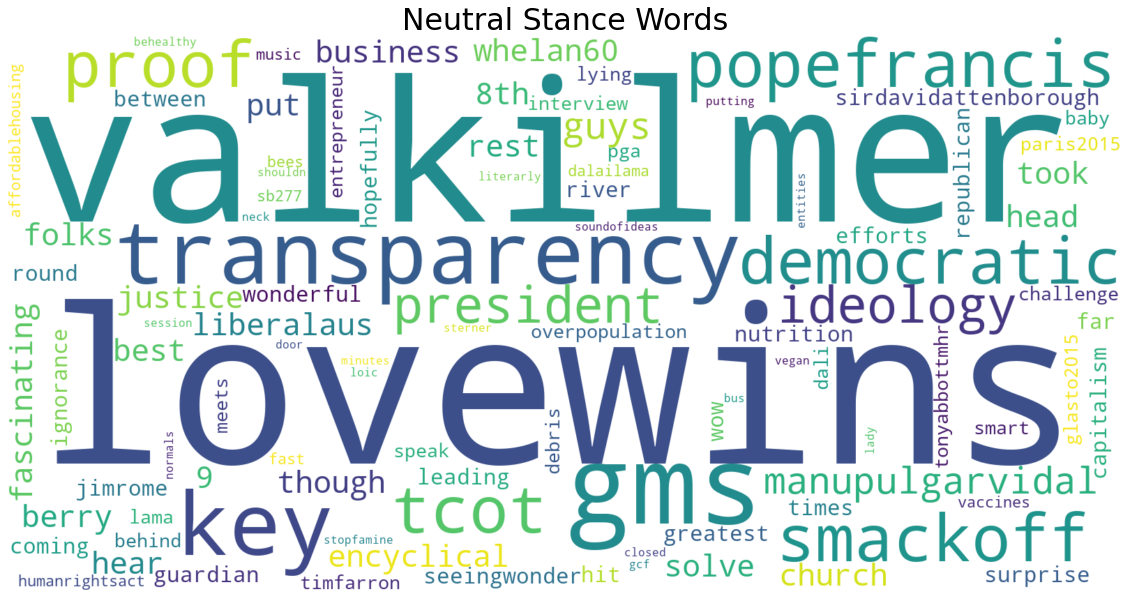

In [ ]:
neutral_dict = df_neutral_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to neutral stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               background_color="white").generate_from_frequencies(neutral_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Neutral Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("neutral_sent.png")